In [28]:
import nest_asyncio
import numpy as np
import pandas as pd
import pyshark
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
nest_asyncio.apply()

In [29]:
fileName = "pcap-run-0.pcap"

pcapsFolder = "powerowl_example_results/pcaps/"

sourceIP = "172.16.0.2" # MTU IP


REMOVE_S_PACKETS = False
apduTypeMap = {
    '0x00000000':"I",
    '0x00000001':"S",
    '0x00000003':"U"
}

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

# Filter all packets that have an APCI and (if present) and ASDU 
cap = pyshark.FileCapture(f"./{pcapsFolder}{fileName}", display_filter="iec60870_104", use_json=True)

In [30]:
num = 0
totSize = 0
df = pd.DataFrame(columns=["timestamp", "length", "src", "dest", "iec104_type", "iec104_asdu_typeid"])
for packet in cap:
    try:
        df.loc[num] = [packet.sniff_time, packet.length, packet.ip.src, packet.ip.dst, apduTypeMap[packet.iec60870_104.type], str(packet.iec60870_asdu.typeid)]
    except AttributeError:
        df.loc[num] = [packet.sniff_time, packet.length, packet.ip.src, packet.ip.dst, apduTypeMap[packet.iec60870_104.type], None]
    totSize += packet.length
    num+=1

if REMOVE_S_PACKETS:
    df = df[df["iec104_type"] != "S"]
    df = df.reset_index(drop=True)  

In [31]:
df["iec104_asdu_typeid"].value_counts(normalize=True)

iec104_asdu_typeid
13     0.780571
45     0.082286
100    0.054857
1      0.045714
103    0.036571
Name: proportion, dtype: float64

33
Average degree: 1.939
Largest eigenvalue: 2.0000000000000004


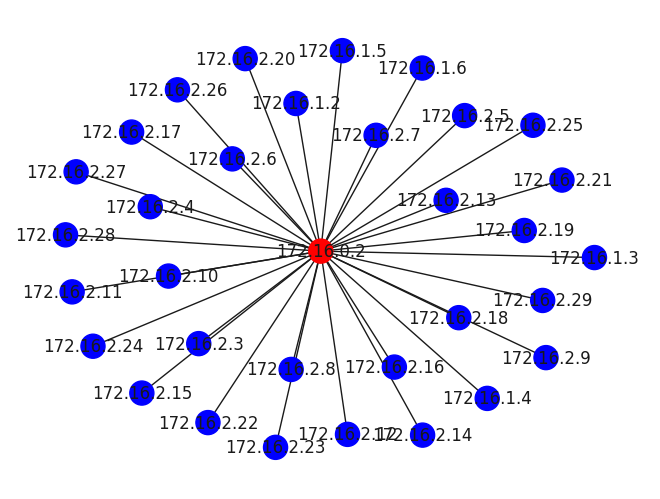

In [32]:
G = nx.Graph()
nodesArr = df["dest"].unique()    
G.add_nodes_from(nodesArr)
color_map = ['red' if node == sourceIP else 'blue' for node in G]
print(len(G.nodes))
for index, pckt in df.iterrows():
    G.add_edge(pckt["src"], pckt["dest"])
nx.draw(G, node_color=color_map, with_labels = True)

avgDegree = np.mean([d[1] for d in list(G.degree())])
L = nx.normalized_laplacian_matrix(G)
e = np.linalg.eigvals(L.toarray())

print(f"Average degree: {avgDegree:.3f}")
print("Largest eigenvalue:", max(e))

In [33]:
totSize = sum(df["length"])
capDuration = (df.loc[len(df)-1]["timestamp"] - df.loc[0]["timestamp"])
throughput = totSize / capDuration.seconds

print(f"Throughput: {throughput:.3f} bytes / second")
print(f"Packet / hour: {((len(df)*3600) / capDuration.seconds):.3f}")

Throughput: 3229.613 bytes / second
Packet / hour: 113283.871


[0.000102, 0.003946, 0.000165, 6e-05, 0.004043, 1e-05, 0.003691, 0.000299, 2.8e-05, 3.9e-05, 8e-06, 0.003781, 1.4e-05, 7.4e-05, 6.5e-05, 5.8e-05, 4.1e-05, 0.003567, 4e-05, 0.00014, 8.8e-05, 1e-05, 0.132206, 0.370236, 0.288091, 3.1e-05, 0.000761, 0.011722, 0.047798, 0.052241, 0.007426, 0.08954, 0.096901, 0.003524, 0.199972, 0.087393, 0.00458, 0.204637, 0.100215, 0.003823, 0.003293, 0.200033, 0.079379, 0.117199, 0.192174, 0.003256, 0.101509, 0.027471, 0.050722, 2.7e-05, 0.053913, 1.2e-05, 0.040282, 0.003729, 1.6e-05, 0.001478, 0.026158, 0.022764, 0.044427, 0.001326, 7e-06, 0.019372, 0.02623, 0.011127, 0.033482, 0.003, 8e-06, 0.046797, 0.048543, 0.002891, 1.4e-05, 0.032405, 0.018145, 0.014037, 0.030417, 0.006822, 1.4e-05, 0.059737, 0.044408, 0.001784, 7e-06, 0.046069, 0.044628, 0.035926, 0.004738, 1.9e-05, 0.055336, 1.2e-05, 0.04432, 0.002651, 1.5e-05, 0.023426, 0.02239, 0.032276, 0.001946, 1e-05, 0.033563, 0.040294, 0.141419, 0.005537, 1.3e-05, 0.022866, 0.026632, 0.040322, 0.001864, 1.5

Text(0, 0.5, 'F(x)')

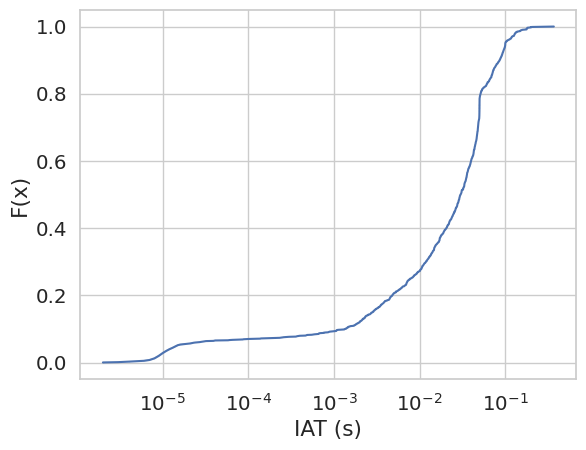

In [34]:
dfC = df[df["dest"] == sourceIP].reset_index(drop=True)

iats = []
for i in range(1, len(dfC)):
    iat = dfC.loc[i]["timestamp"] - dfC.loc[i-1]["timestamp"]
    iats.append(iat.microseconds / 1000000)
print(iats)

x = np.sort(iats)
y = 1. * np.arange(len(iats)) / (len(iats) - 1)

ax = sns.lineplot(x=x, y=y)
plt.xscale("log")
ax.set_xlabel("IAT (s)")
ax.set_ylabel("F(x)")

Num of unique hosts: 33
Num a2C: 1646 (84.37%)
Num C2a: 305 (15.63%)


/tmp/ipykernel_2566592/3216231993.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot({"a2C": ((numA2C / (numC2A + numA2C)) * 100), "C2a":((numC2A / (numC2A + numA2C)) * 100)}, palette=custom_palette)


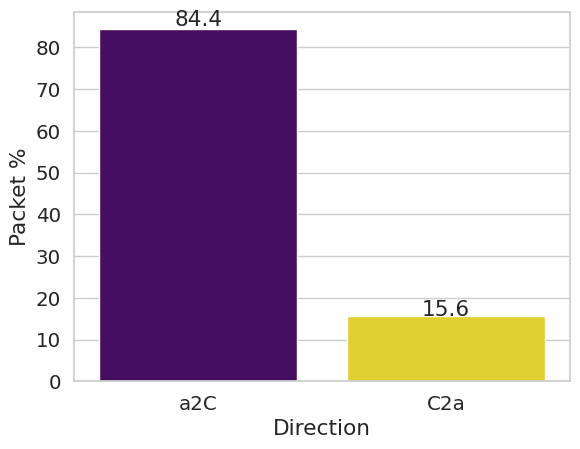

In [35]:
sns.set_theme(style="whitegrid",font_scale=1.3)
numC2A = len(df[df["src"] == sourceIP])
numA2C = len(df) - numC2A
uniqueHosts = len(df["src"].unique())

print(f"Num of unique hosts: {uniqueHosts}")
print(f"Num a2C: {numA2C} ({((numA2C / (numC2A + numA2C)) * 100):.2f}%)")
print(f"Num C2a: {numC2A} ({((numC2A / (numC2A + numA2C)) * 100):.2f}%)")

purple_hex = "#4B006F"  # Approximate
yellow_hex = "#FEE811"  # Approximate

custom_palette = [purple_hex, yellow_hex]
ax = sns.barplot({"a2C": ((numA2C / (numC2A + numA2C)) * 100), "C2a":((numC2A / (numC2A + numA2C)) * 100)}, palette=custom_palette)
ax.set_ylabel("Packet %")
ax.set_xlabel("Direction")
show_values(ax, space=0)

count    1951.000000
mean      102.632496
std        47.058237
min        72.000000
25%        82.000000
50%        86.000000
75%        94.000000
max       318.000000
Name: length, dtype: float64


Text(0, 0.5, 'Bytes / Packet')

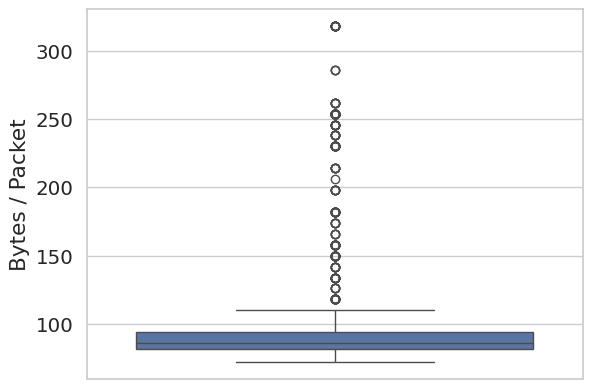

In [36]:
print(df["length"].describe())
ax = sns.boxplot(df["length"])
ax.set_ylabel("Bytes / Packet")

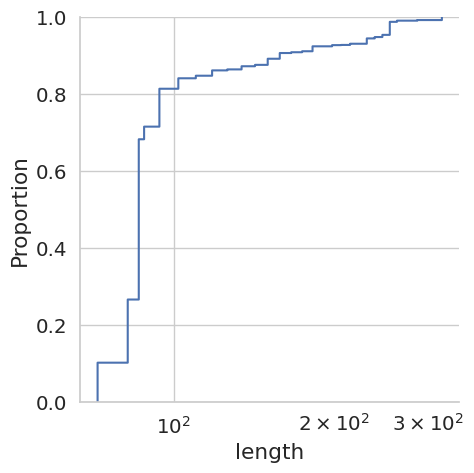

In [37]:
x = np.sort(df["length"])
y = 1. * np.arange(len(df["length"])) / (len(df["length"]) - 1)

ax = sns.displot(df["length"], kind="ecdf", log_scale=True)

Text(0, 0.5, 'Bytes / Packet')

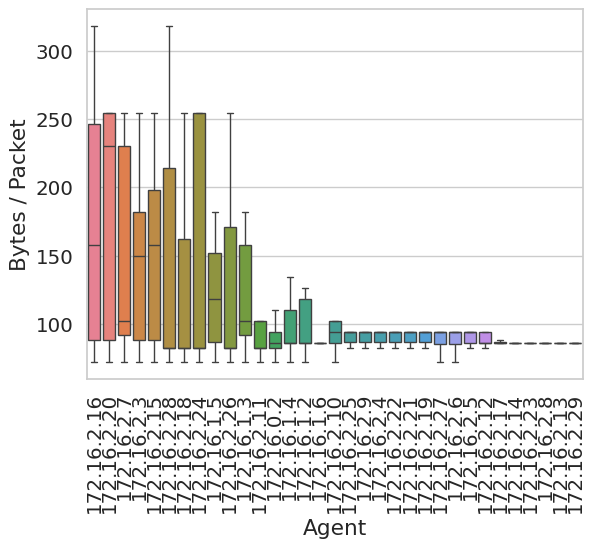

In [38]:
# Use the data going in both directions
dfFrom = df#df[df["src"] != sourceIP].reset_index(drop=True)
aIps = dfFrom["src"].unique()
dfSizes = pd.DataFrame(columns=aIps)
for ip in aIps:
    dfFromIp = dfFrom[(dfFrom["src"] == ip) | (dfFrom["dest"] == ip)].reset_index(drop=True)
    dfSizes[ip] = dfFromIp["length"]
dfSizes = dfSizes.reindex(dfSizes.mean().sort_values(ascending=False).index, axis=1)
ax = sns.boxplot(dfSizes, showfliers=False)
res = plt.xticks(rotation=90)
ax.set_xlabel("Agent")
ax.set_ylabel("Bytes / Packet")

In [39]:
df["iec104_asdu_typeid"].value_counts(normalize=True) * 100

iec104_asdu_typeid
13     78.057143
45      8.228571
100     5.485714
1       4.571429
103     3.657143
Name: proportion, dtype: float64

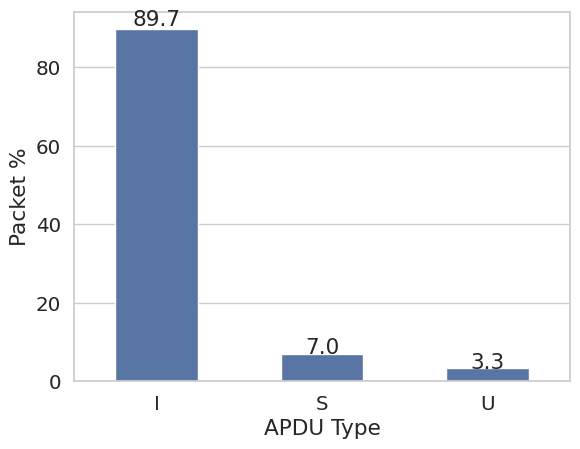

In [40]:
iec104_type_freq = df["iec104_type"].value_counts(normalize=True) * 100
ax = sns.barplot(iec104_type_freq, width=0.5)
ax.set_xlabel("APDU Type")
ax.set_ylabel("Packet %")
show_values(ax)

Text(30.0, 0.5, 'I Packet / S Packet')

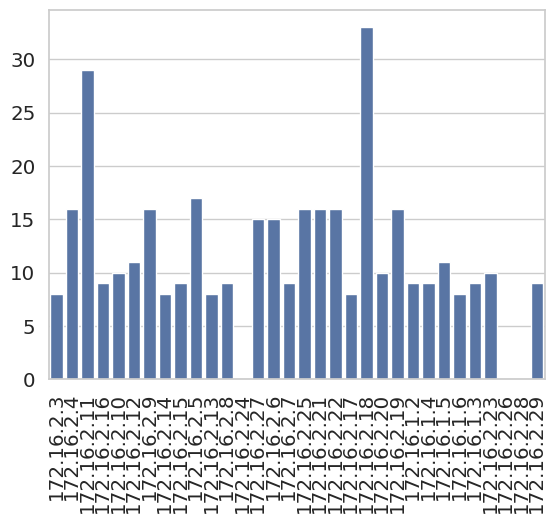

In [41]:
# S-Rate calculation
hosts = df["dest"].unique()
actuators = np.delete(hosts, np.where(hosts == sourceIP))

sRates = {}
for actuator in actuators:
    dfI = df[(df["src"] == actuator) & (df["iec104_asdu_typeid"] == "13")].reset_index(drop=True)
    dfS = df[(df["dest"] == actuator)].reset_index(drop=True)
    countI = dfI["iec104_type"].value_counts()
    countS = dfS["iec104_type"].value_counts()
    try:
        sRate = int(countI.I / countS.S)
    except AttributeError as e:
        sRate = float("NaN")

    sRates[actuator] = sRate

sns.barplot(sRates)
res = plt.xticks(rotation=90)
ax.set_xlabel("Agent")
ax.set_ylabel("I Packet / S Packet")

    